# **POTATO DISEASE CLASSIFICATION**

**Importing all the Dependencies**

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

# Check for GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("✅ GPU is available")
    print("Using GPU:", gpus)
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("❌ GPU not available. Using CPU")


✅ GPU is available
Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


**Setting the constants**

In [2]:
BATCH_SIZE = 16
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

**Importing the image data into tensorflow dataset object**

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
len(dataset)

135

In [5]:
501*32

16032

In [6]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(16, 256, 256, 3)
[0 1 1 0 1 0 1 0 1 1 1 1 0 1 2 1]


As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels

**Visualizing some of the images from the dataset**

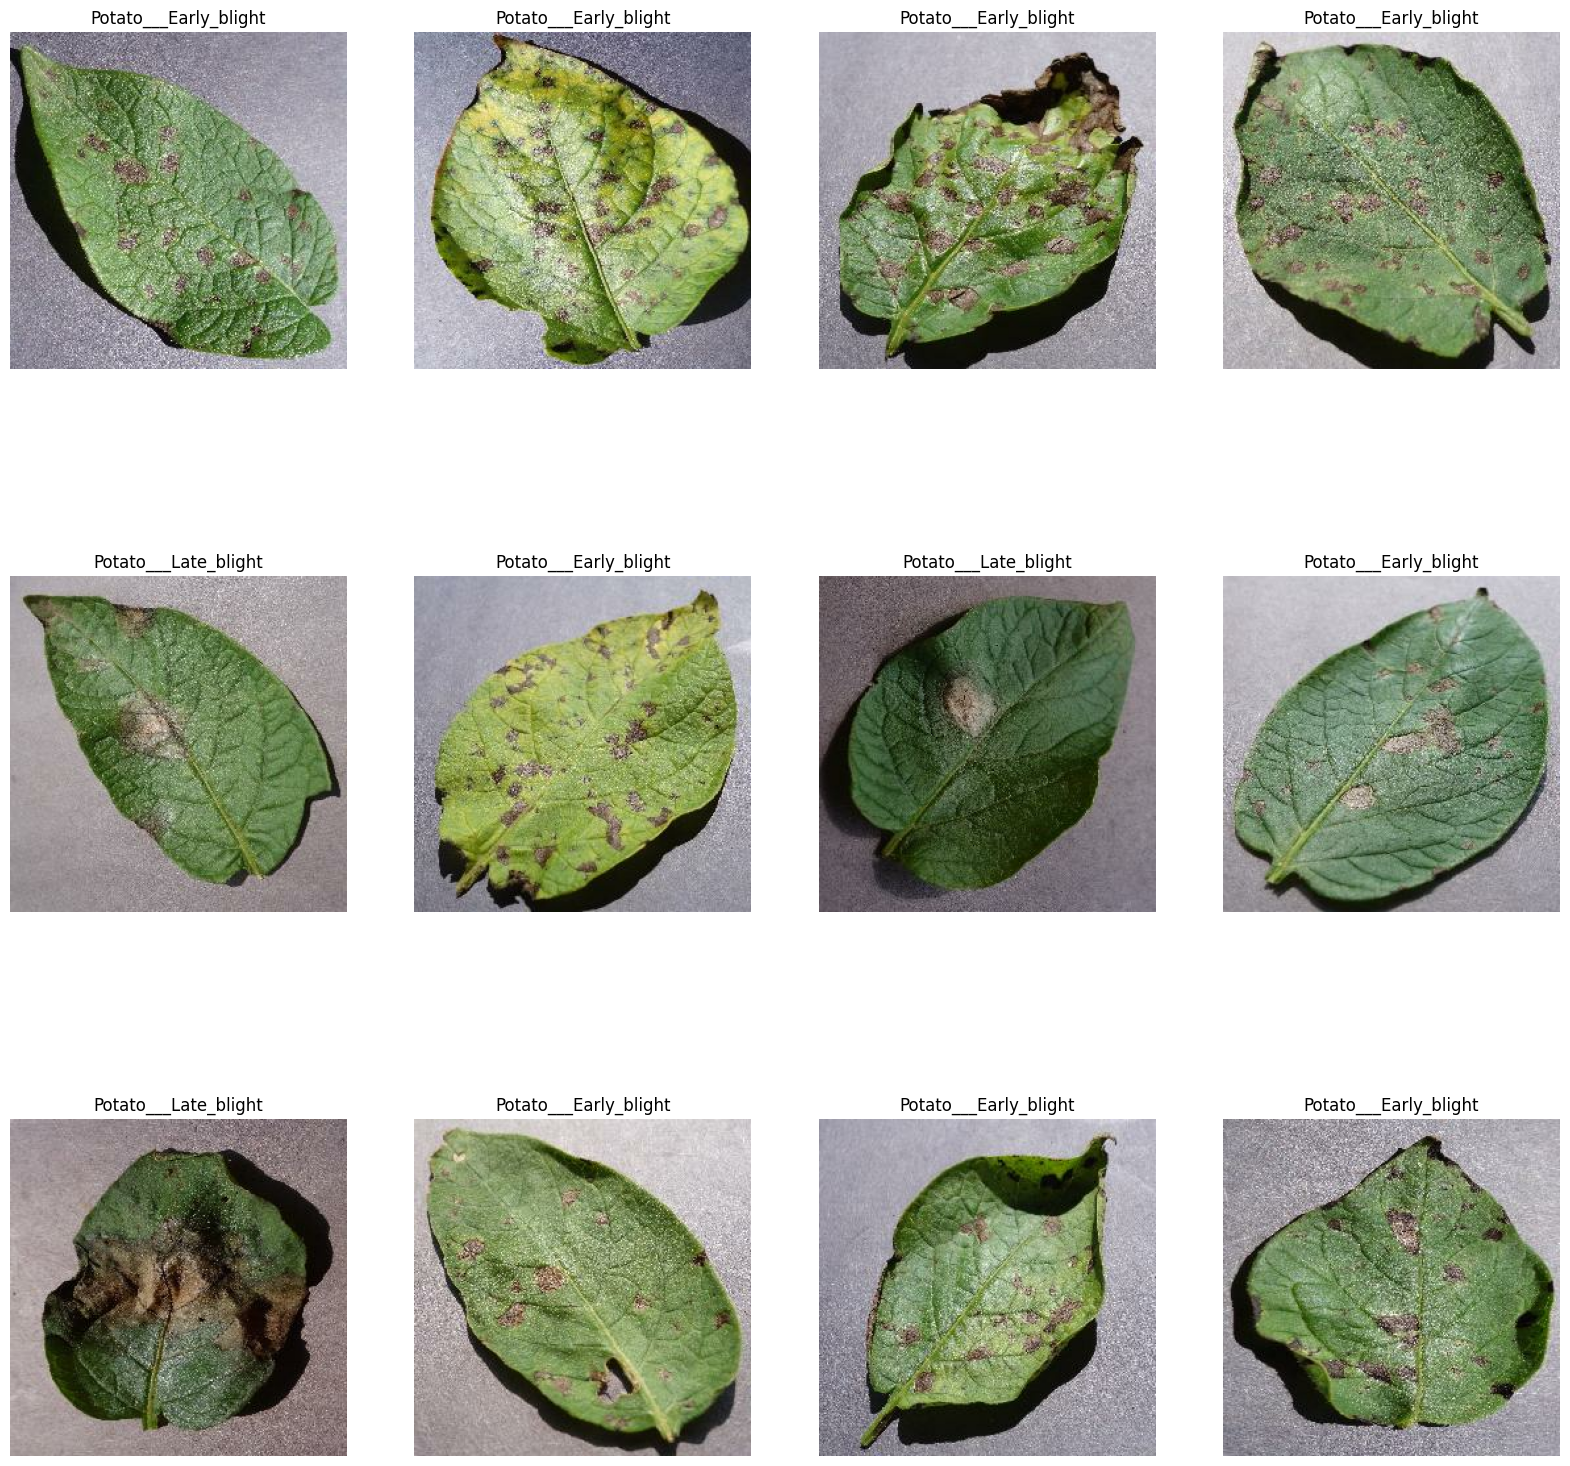

In [8]:
plt.figure(figsize=(20,20))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

**Created a Function to Split Dataset**<br>
Dataset should be divided into 3 subsets, namely:<br>
~Training set : Dataset to be used while training<br>
~Validation set: Dataset to be tested against while training<br>
~Test set : Dataset to be tested against after we trained a model<br>

In [9]:
def get_dataset_partitions_tf(ds, train_split   = 0.8 , val_split=0.1 , test_split = 0.1 , shuffle=True , shuffle_size = 1000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size , seed=12)
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds , val_ds , test_ds

In [10]:
train_ds , val_ds , test_ds = get_dataset_partitions_tf(dataset)

In [11]:
len(train_ds)

108

In [12]:
len(val_ds)

13

In [13]:
len(test_ds)

14

**Cache, Shuffle, and Prefetch the Dataset**

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

**Creating a Layer for Resizing and Normalization**

In [15]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1./255),
])

**Data Augmentation**

In [16]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

**Applying Data Augmentation to Train Dataset**

In [17]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

**Model Architecture**

In [18]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (16, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (16, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (16, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (16, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (16, 60, 60, 64)         

In [20]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [21]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
108/108 [==============================] - 19s 90ms/step - loss: 0.7724 - accuracy: 0.6233 - val_loss: 0.5105 - val_accuracy: 0.7850
Epoch 2/50
108/108 [==============================] - 7s 67ms/step - loss: 0.4557 - accuracy: 0.8171 - val_loss: 0.6349 - val_accuracy: 0.7150
Epoch 3/50
108/108 [==============================] - 6s 58ms/step - loss: 0.3768 - accuracy: 0.8484 - val_loss: 0.2895 - val_accuracy: 0.8800
Epoch 4/50
108/108 [==============================] - 8s 73ms/step - loss: 0.2543 - accuracy: 0.9010 - val_loss: 0.2909 - val_accuracy: 0.8800
Epoch 5/50
108/108 [==============================] - 8s 73ms/step - loss: 0.2065 - accuracy: 0.9230 - val_loss: 0.3060 - val_accuracy: 0.8800
Epoch 6/50
108/108 [==============================] - 7s 69ms/step - loss: 0.1881 - accuracy: 0.9248 - val_loss: 0.2485 - val_accuracy: 0.8950
Epoch 7/50
108/108 [==============================] - 7s 63ms/step - loss: 0.1972 - accuracy: 0.9294 - val_loss: 0.2014 - val_accuracy: 0.910

In [22]:
scores = model.evaluate(test_ds)


14/14 [==============================] - 1s 18ms/step - loss: 0.0889 - accuracy: 0.9777


In [23]:
scores


[0.08886046707630157, 0.9776785969734192]

In [24]:
history


In [25]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 108}

In [26]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [27]:
type(history.history['loss'])

list

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

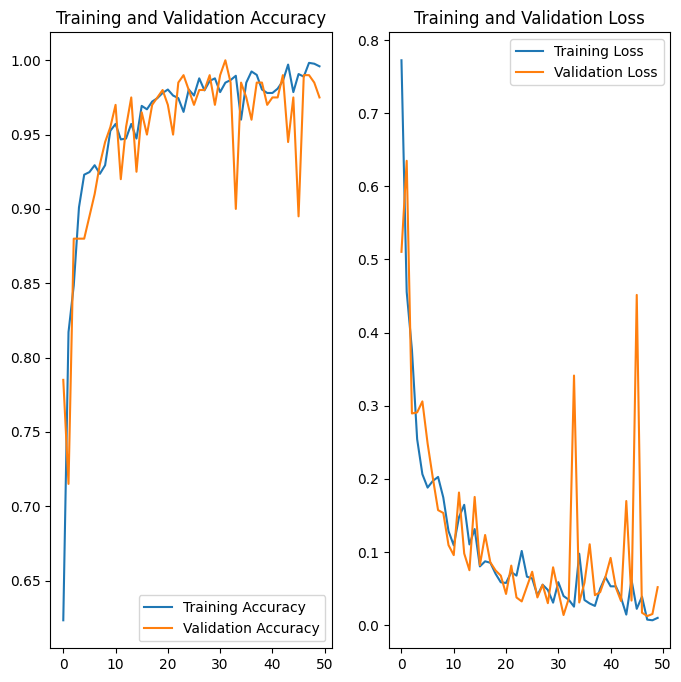

In [30]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 20ms/step
predicted label: Potato___Early_blight


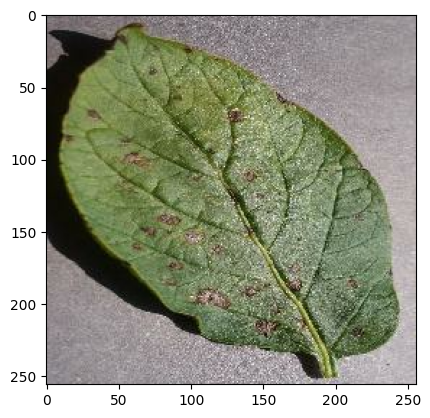

In [33]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [34]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 24ms/step


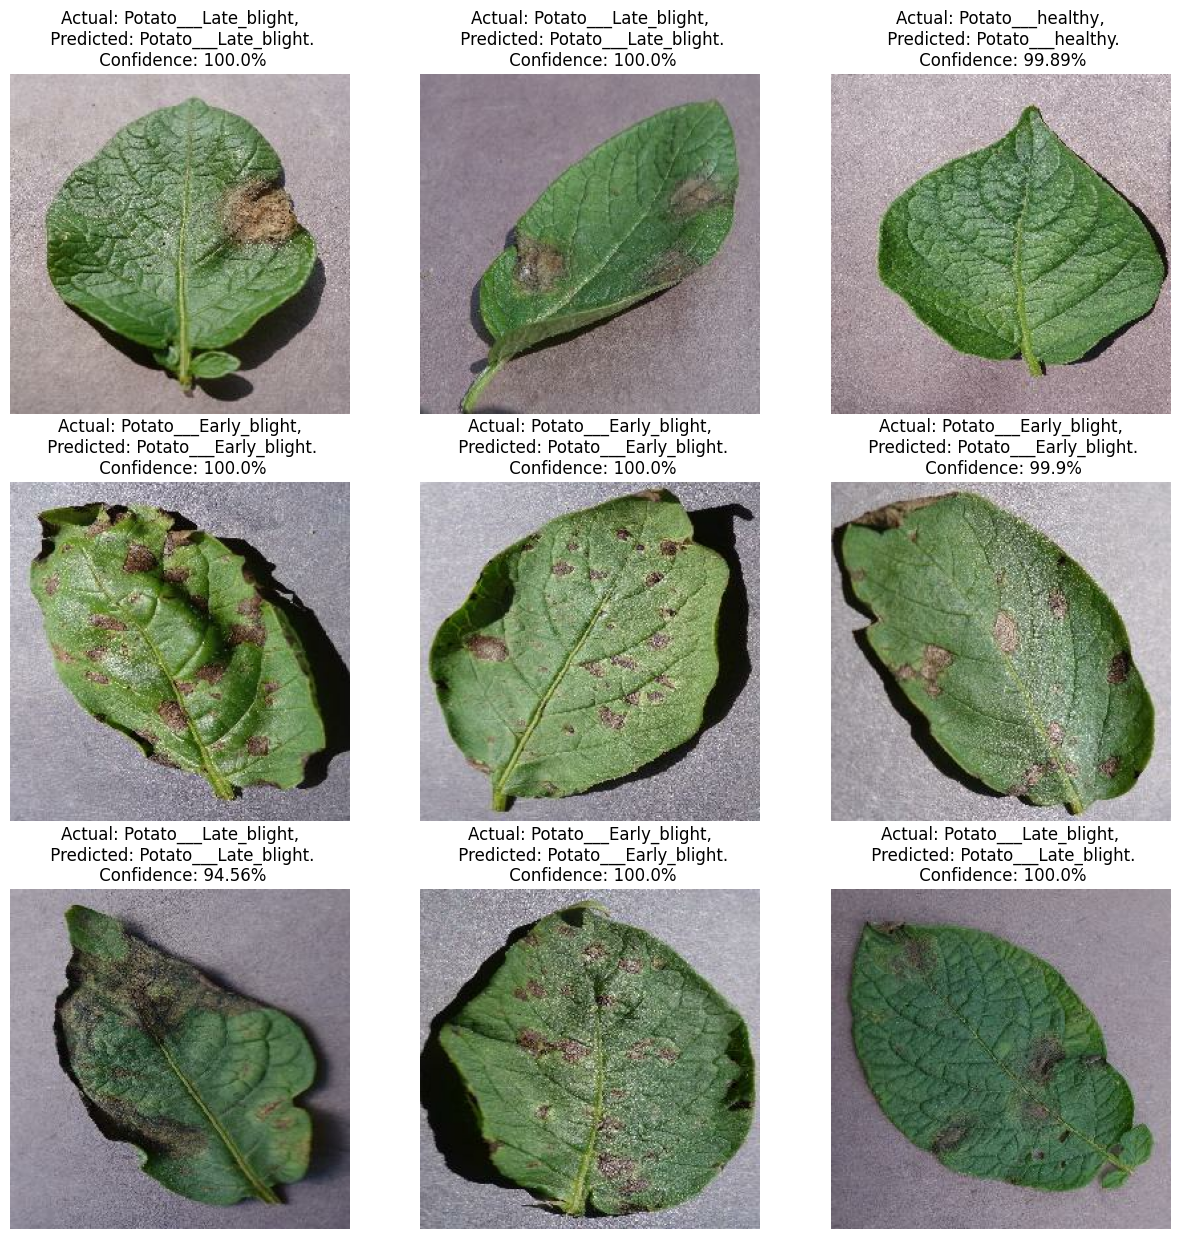

In [35]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [36]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
